## Table of Contents ##
- [1 - Loading Dataset](#1)
- [2 - Overview of the Problem set](#2)
    - [2.1 - Train Test Split](#2-1)
    - [2.2 - Reshape the training and test data sets](#2-2)
    - [2.3 - Center and standardize dataset](#2-3)
- [3 - General Architecture of the learning algorithm](#3)
- [4 - Building the parts of our algorithm](#4)
    - [4.1 - Initializing parameters](#4-1)
    - [4.2 - Forward and Backward propagation](#4-2)
    - [4.3 - Optimization](#4-3)
    - [4.4 - Prediction](#4-4)
    - [4.5 - Merging all functions into a model](#4-5)
- [5 - Predicting the Presence of Figures on a Document Page](#5)
    - [5.1 - Choosing learning rate](#5-1)
    - [5.2 - Training a model](#5-2)
    - [5.3 - Checking results](#5-3)
    - [5.4 - Cost function / gradients plot](#5-4)
    - [5.5 - Measuring quality](#5-5)
- [6 - Predicting the Presence of Tables on a Document Page](#6)
    - [6.1 - Preparing train and test sets](#6-1)
    - [6.2 - Choosing learning rate](#6-2)
    - [6.3 - Training a model](#6-3)
    - [6.4 - Checking results](#6-4)
    - [6.5 - Cost function / gradients plot](#6-5)
    - [6.6 - Measuring quality](#6-6)
- [7 - Summary](#7)

In [1]:
# import os
# import sys
# import fitz
# from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import conf

In [2]:
# import pandas as pd
# df = pd.read_csv("/Users/michael/Projects/tables_recognition/data/metadata.csv")
# df_validation = df[df['pdf_id'] == "Local-authority-2024-ENG-1"]

In [3]:
# y_table = df["table"].to_numpy()
# y_fig = df["figure"].to_numpy()
# y_fig_valid = df_validation["figure"].to_numpy()

In [4]:
# file_path = "/Users/michael/Projects/tables_recognition/data/taub_dataset.h5"
# file_mode = 'a'  # 'a' for append mode, 'w' for write mode (creates a new file)
# with h5py.File(file_path, file_mode) as f:
#     # Create the dataset and store the vectors
#     # f.create_dataset('y_table', data=y_table)
#     # f.create_dataset('y_fig', data=y_fig)
#     # f.create_dataset('y_fig_valid', data=y_fig_valid)
#     f.close()

<a name='1'></a>
# Loading Dataset #

In [5]:
# dataset_path = "/Users/michael/Projects/tables_recognition/data/taub_dataset.h5"

In [2]:
def load_dataset(dataset_path: str) -> tuple:
    """
    Load dataset from an HDF5 file.
    :param dataset_path: Path to the HDF5 dataset file.
    :return: tuple: A tuple containing the following:
        - x (np.ndarray): Array of image vectors.
        - y_fig (np.ndarray): Array of figure labels.
        - y_table (np.ndarray): Array of table labels.
    """
    ds = h5py.File(dataset_path, "r")
    x = np.array(ds['x'][:])
    y_table = np.array(ds['y_table'][:])
    y_fig = np.array(ds['y_fig'][:])
    y_table = y_table.reshape((1, y_table.shape[0]))
    y_fig = y_fig.reshape((1, y_fig.shape[0]))
    ds.close()

    return x, y_fig, y_table

<a name='2'></a>
# Overview of the Problem set #

**Problem Statement**: We have a dataset of 7 reports by Taub Center ("taub_dataset.h5") containing:
    - a set of 257 pages labeled as containing figure (y_fig=1) or not containing (y_fig=0)
    - and labeled as containing table (y_table=1) or not containing (y_table=0)
    - each image of page is of shape (681, 440, 3) where 3 is for the 3 channels (RGB).

We will build a simple image-recognition algorithm that can correctly classify pages as "with figure" or "without figure".

Let's get more familiar with the dataset. Load the data by running the following code.

y_table: [0]
y_fig: [1]


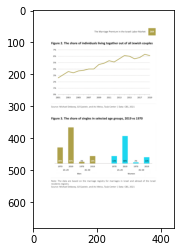

In [3]:
x, y_fig, y_table = load_dataset(conf.dataset_path)
index = 2
plt.imshow(x[index])
print("y_table:", y_table[:,index])
print("y_fig:", y_fig[:,index])

<a name='2-1'></a>
## Train Test Split ##
We need to split data randomly between train and test set

In [8]:
def train_test_split(x: np.ndarray,
                     y_table: np.ndarray,
                     y_fig: np.ndarray,
                     problem: str,
                     random_seed: int = 42,
                     train_size: float = 0.8) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split the dataset into training and testing sets.

    :param x: (np.ndarray) Array of image vectors.
    :param y_table: (np.ndarray) Array of table labels.
    :param y_fig: (np.ndarray) Array of figure labels.
    :param problem: (str) Type of problem, either "table" or "figure".
    :param random_seed: (int) Random seed for reproducibility. Default is 42.
    :param train_size: (float) Proportion of the dataset to include in the training set. Default is 0.8.
    :return: tuple: A tuple containing the following:
        - train_x (np.ndarray): Training set of image vectors.
        - test_x (np.ndarray): Testing set of image vectors.
        - train_y (np.ndarray): Training set of labels (table or figure).
        - test_y (np.ndarray): Testing set of labels (table or figure).
    """
    np.random.seed(seed=random_seed)
    labels = y_fig if problem == "figure" else y_table
    unique_labels = np.unique(labels)

    # Initialize arrays to store indices for train and test sets
    train_indices = np.array([], dtype=int)
    test_indices = np.array([], dtype=int)

    # Iterate over unique labels
    for label in unique_labels:
        label_indices = np.where(labels == label)[1]
        np.random.shuffle(label_indices)

        split_point = int(train_size * len(label_indices))

        # Append the indices to train and test sets
        train_indices = np.concatenate([train_indices, label_indices[:split_point]])
        test_indices = np.concatenate([test_indices, label_indices[split_point:]])
    # Shuffle the train and test sets
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    # Use the indices to get our train and test sets
    train_x, train_y = x[train_indices], labels[:, train_indices]
    test_x, test_y = x[test_indices], labels[:, test_indices]

    assert labels.shape[0] == train_y.shape[0] == test_y.shape[0]
    assert x.shape[1:] == train_x.shape[1:] == test_x.shape[1:]

    return train_x, test_x, train_y, test_y

In [9]:
def get_train_test_set(dataset_path: str,
                       problem: str,
                       random_seed: int=42,
                       train_size: float=0.8) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load the dataset, split it into training and testing sets, and return the sets.

    :param dataset_path: (str) Path to the dataset.
    :param problem: (str) Type of problem, either "table" or "figure".
    :param random_seed: (int) Random seed for reproducibility. Default is 42.
    :param train_size: (float) Proportion of the dataset to include in the training set. Default is 0.8.
    :return: tuple: A tuple containing the following:
        - train_x (np.ndarray): Training set of image vectors.
        - test_x (np.ndarray): Testing set of image vectors.
        - train_y (np.ndarray): Training set of labels (table or figure).
        - test_y (np.ndarray): Testing set of labels (table or figure).
    """
    x, y_fig, y_table = load_dataset(dataset_path=dataset_path)
    train_x, test_x, train_y, test_y = train_test_split(x=x, y_table=y_table, y_fig=y_fig, problem=problem, random_seed=random_seed, train_size=train_size)
    return train_x, test_x, train_y, test_y

In [10]:
train_x, test_x, train_y, test_y = get_train_test_set(dataset_path="/Users/michael/Projects/tables_recognition/data/taub_dataset.h5", problem="figure")

train_y: [1]


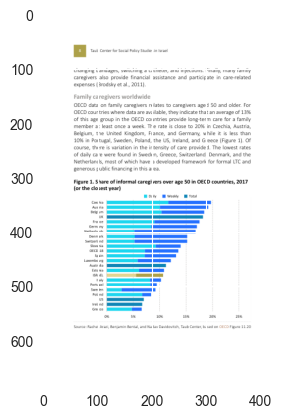

In [11]:
index = 4
plt.imshow(train_x[index])
print("train_y:", train_y[:,index])

In [12]:
m_train = train_x.shape[0]
m_test = test_x.shape[0]
height_px = train_x.shape[1]
width_px = train_x.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height of each image: height_px = " + str(height_px))
print ("Width of each image: width_px = " + str(width_px))
print ("Each image is of size: (" + str(height_px) + ", " + str(width_px) + ", 3)")
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 204
Number of testing examples: m_test = 53
Height of each image: height_px = 681
Width of each image: width_px = 440
Each image is of size: (681, 440, 3)
train_x shape: (204, 681, 440, 3)
train_y shape: (1, 204)
test_x shape: (53, 681, 440, 3)
test_y shape: (1, 53)


<a name='2-2'></a>
## Reshape the training and test data sets ##
So that images of size (height_px, width_px, 3) are flattened into single vectors of shape (height\_px $*$ width\_px $*$ 3, 1).

In [13]:
train_x_flatten = train_x.reshape(train_x.shape[0],-1).T
test_x_flatten = test_x.reshape(test_x.shape[0],-1).T

In [14]:
print ("train_x_flatten shape: " + str(train_x_flatten.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_flatten shape: " + str(test_x_flatten.shape))
print ("test_y shape: " + str(test_y.shape))

train_x_flatten shape: (898920, 204)
train_y shape: (1, 204)
test_x_flatten shape: (898920, 53)
test_y shape: (1, 53)


<a name='2-3'></a>
## Center and standardize dataset ##
Meaning that we substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [15]:
train_x_stand = train_x_flatten / 255.
test_x_stand = test_x_flatten / 255.

<a name='3'></a>
# General Architecture of the learning algorithm #

We will build a Logistic Regression, using a Neural Network mindset.

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

<a name='4'></a>
# Building the parts of our algorithm #

In [16]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid of z
    :param z: A scalar or numpy array of any size.
    :return: sigmoid(z)
    """
    s = 1 / (1+ np.exp(-z))
    return s

<a name='4-1'></a>
## Initializing parameters ##

We will initialize w as a vector of zeros.

In [17]:
def initialize_with_zeros(dim: int) -> tuple[np.ndarray, float]:
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    :param dim: size of the w vector we want (or number of parameters in this case)
    :return:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim, 1))
    b = .0

    return w, b

<a name='4-2'></a>
## Forward and Backward propagation ##

Now that our parameters are initialized, we can do the "forward" and "backward" propagation steps for learning the parameters.

### Propagate ###

Forward Propagation:
- We get X
- We compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas we will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [18]:
def propagate(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray) -> tuple[dict, float]:
    """
    Implement the cost function and its gradient for the propagation explained above
    :param w: weights, a numpy array of size (height_px * width_px * 3, 1)
    :param b: bias, a scalar
    :param X: data of size (height_px * width_px * 3, number of examples)
    :param Y: true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    :return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X) + b)

    # Compute cost function
    cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A-Y) / m

    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [19]:
# ww = initialize_with_zeros(train_x_stand.shape[0])[0]
# bb = 0.
# ii = 1
# lr = .00005

In [20]:
# print("\niteration:", ii)
# print("\nw\n", ww)
# zz = np.dot(ww.T,train_x_stand) + 0.
# print("\nlinreg\n", zz)
# dd = sigmoid(zz)
# print("\nsigmoid\n", dd)
# cost = - np.sum(train_y * np.log(dd) + (1-train_y)*np.log(1-dd)) / train_x_stand.shape[1]
# print("\ncost\n", cost)
# dw = np.dot(train_x_stand, (dd - train_y).T) / train_x_stand.shape[1]
# db = np.sum(dd-train_y) / train_x_stand.shape[1]
#
# ww = ww - lr * dw
# bb = bb - lr * db
# ii += 1

<a name='4-3'></a>
## Optimization ##
- We have initialized our parameters.
- We are also able to compute a cost function and its gradient.
- Now, we want to update the parameters using gradient descent.

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [21]:
def optimize(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray, num_iterations: int = 100,
             learning_rate: float = 0.009, print_cost: bool = False) -> tuple[dict, dict, float]:
    """
    This function optimizes w and b by running a gradient descent algorithm
    :param w: weights, a numpy array of size (height_px * width_px * 3, 1)
    :param b: bias, a scalar
    :param X: data of shape (height_px * width_px * 3, number of examples)
    :param Y: true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    :param num_iterations: number of iterations of the optimization loop
    :param learning_rate: learning rate of the gradient descent update rule
    :param print_cost: True to print the loss every 100 steps
    :return:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # Update weights
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

<a name='4-4'></a>
## Prediction ##
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X.
To do it we need:
1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [22]:
def predict(w: np.ndarray, b: float, X: np.ndarray) -> np.ndarray:
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    :param w: weights, a numpy array of size (height_px * width_px * 3, 1)
    :param b: bias, a scalar
    :param X: data of size (height_px * width_px * 3, number of examples)
    :return: Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a figure or table being present in the page
    A = sigmoid(np.dot(w.T, X) + b)


    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    return Y_prediction

We've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - Computing the cost and its gradient
    - Updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

<a name='4-5'></a>
## Merging all functions into a model ##

We will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

To implement the model function we will se the following notation:
    - Y_prediction_test for our predictions on the test set
    - Y_prediction_train for our predictions on the train set
    - parameters, grads, costs for the outputs of optimize()

In [23]:
def model(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, num_iterations: int = 2000,
          learning_rate: float = 0.5, print_cost: bool = False) -> dict:
    """
    Builds the logistic regression model by calling the function we've implemented previously
    :param X_train: training set represented by a numpy array of shape (height_px * width_px * 3, m_train)
    :param Y_train: training labels represented by a numpy array (vector) of shape (1, m_train)
    :param X_test: test set represented by a numpy array of shape (height_px * width_px * 3, m_test)
    :param Y_test: test labels represented by a numpy array (vector) of shape (1, m_test)
    :param num_iterations: hyperparameter representing the number of iterations to optimize the parameters
    :param learning_rate: hyperparameter representing the learning rate used in the update rule of optimize()
    :param print_cost: Set to True to print the cost every 100 iterations
    :return: d -- dictionary containing information about the model.
    """

    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations=num_iterations, learning_rate=learning_rate, print_cost=print_cost)

    w = params["w"]
    b = params["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

Let's see how it works

<a name='5'></a>
# Predicting the Presence of Figures on a Document Page #

<a name='5-1'></a>
## Choosing learning rate ##

In order for Gradient Descent to work we must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates.

In [24]:
learning_rates = [0.01, 0.001, 0.0001, 0.00003]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_x_stand, train_y, test_x_stand, test_y, num_iterations=2100, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

Training a model with learning rate: 0.01


/var/folders/8m/pdb3kxls26vfh6fx96vt11380000gp/T/ipykernel_34506/1526006666.py:7: RuntimeWarning: overflow encountered in exp
  s = 1 / (1+ np.exp(-z))
/var/folders/8m/pdb3kxls26vfh6fx96vt11380000gp/T/ipykernel_34506/2450089686.py:18: RuntimeWarning: divide by zero encountered in log
  cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m
/var/folders/8m/pdb3kxls26vfh6fx96vt11380000gp/T/ipykernel_34506/2450089686.py:18: RuntimeWarning: invalid value encountered in multiply
  cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m



-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------

Training a model with learning rate: 3e-05

-------------------------------------------------------



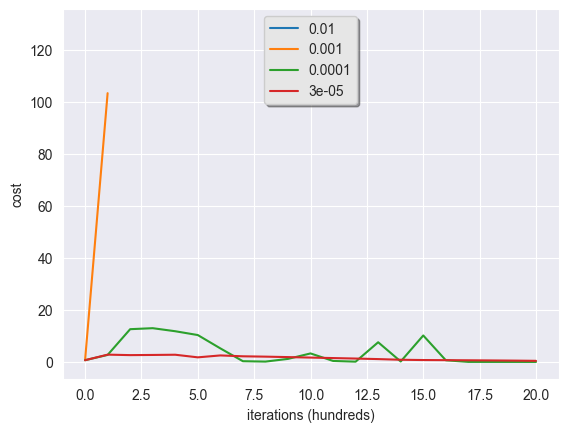

In [25]:
for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
# Set Y-axis limit to 10
# plt.ylim(0, 10)

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

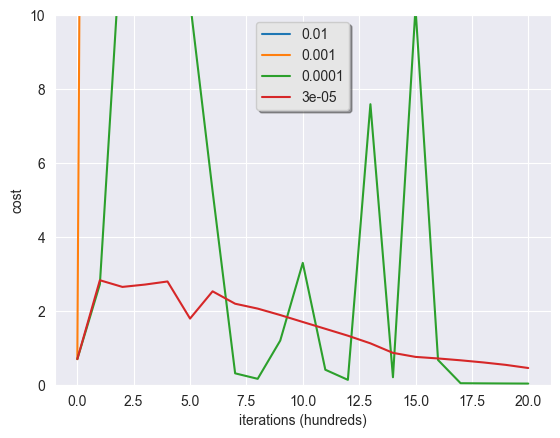

In [26]:
for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
# Set Y-axis limit to 10
plt.ylim(0, 10)

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

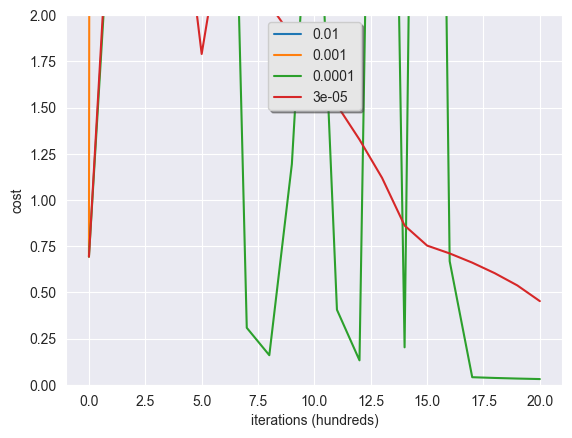

In [27]:
for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
# Set Y-axis limit to 10
plt.ylim(0, 2)

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**:
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may blow up and raise RuntimeWarnings:
    - overflow encountered in exp; s = 1 / (1+ np.exp(-z))
    - divide by zero encountered in log; cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m
    - invalid value encountered in multiply; cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m

- Learning rate 0.0001 is also too large, we can se that the cost oscillating up and down.
- A lower cost doesn't mean a better model. We have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.


<a name='5-2'></a>
## Training a model ##

In [28]:
logistic_regression_model_00003 = model(train_x_stand, train_y, test_x_stand, test_y, num_iterations=5000, learning_rate=0.00003, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 2.826988
Cost after iteration 200: 2.646462
Cost after iteration 300: 2.709695
Cost after iteration 400: 2.793566
Cost after iteration 500: 1.789733
Cost after iteration 600: 2.526800
Cost after iteration 700: 2.191420
Cost after iteration 800: 2.059525
Cost after iteration 900: 1.885142
Cost after iteration 1000: 1.697744
Cost after iteration 1100: 1.513052
Cost after iteration 1200: 1.326518
Cost after iteration 1300: 1.119574
Cost after iteration 1400: 0.861488
Cost after iteration 1500: 0.752882
Cost after iteration 1600: 0.710415
Cost after iteration 1700: 0.660621
Cost after iteration 1800: 0.603479
Cost after iteration 1900: 0.537395
Cost after iteration 2000: 0.452311
Cost after iteration 2100: 0.128279
Cost after iteration 2200: 0.114696
Cost after iteration 2300: 0.111166
Cost after iteration 2400: 0.107887
Cost after iteration 2500: 0.104833
Cost after iteration 2600: 0.101979
Cost after iteration 2700: 0.099306
Cost

**Comment**: Training accuracy is close to 100%. This is a good sanity check: our model is working and has high enough capacity to fit the training data. Test accuracy is 77%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier.
Also, we can see that the model is clearly overfitting the training data.

<a name='5-3'></a>
## Checking results ##

y = 1, we predicted that it is a "0"


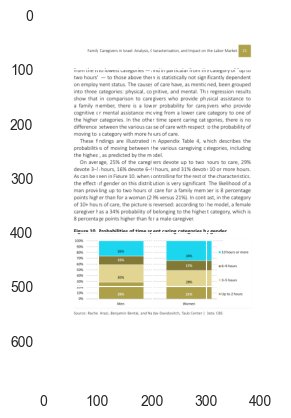

In [52]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_x[index])
print ("y = " + str(test_y[0,index]) + ", we predicted that it is a \"" + str(int(1-logistic_regression_model_00003['Y_prediction_test'][0,index])) +  "\"")

y = 1, we predicted that it is a "1"


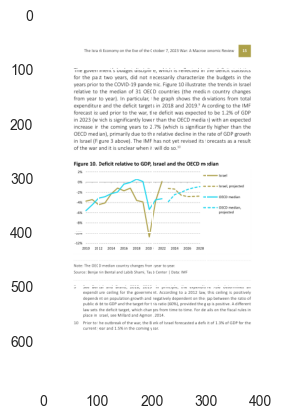

y = 1, we predicted that it is a "1"


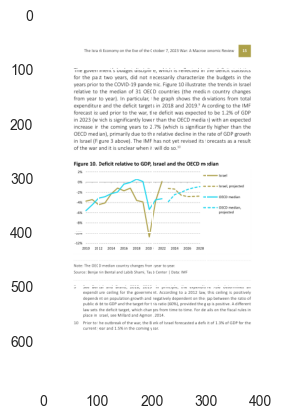

y = 1, we predicted that it is a "1"


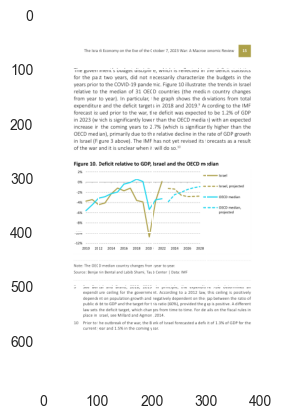

In [51]:
# Example of a picture that was correctly classified.
index = 3
plt.imshow(test_x[index])
print ("y = " + str(test_y[0,index]) + ", we predicted that it is a \"" + str(int(1-logistic_regression_model_00003['Y_prediction_test'][0,index])) +  "\"")

<a name='5-4'></a>
## Cost function / gradients plot ##
Let's also plot the cost function and the gradients.

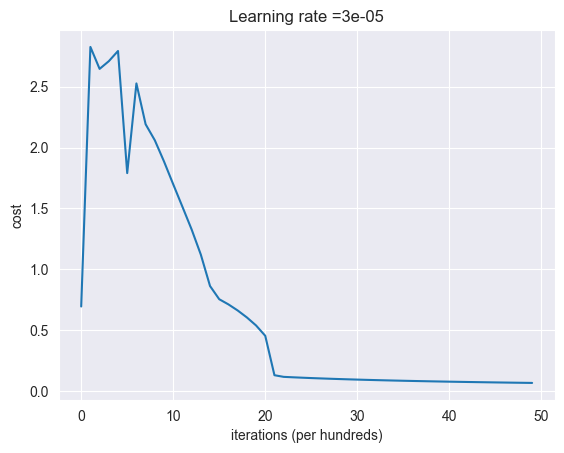

In [31]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model_00003['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model_00003["learning_rate"]))
plt.show()

**Interpretation**:
We can see the cost blowing up and then decreasing. It shows that the parameters are being learned. However, we see an elbow on 2100 iterations (Cost after iteration 2000: 0.452311, after iteration 2100: 0.128279). Let's decrease the number of iterations. We might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.

In [32]:
logistic_regression_model = model(train_x_stand, train_y, test_x_stand, test_y, num_iterations=2100, learning_rate=0.00003, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 2.826988
Cost after iteration 200: 2.646462
Cost after iteration 300: 2.709695
Cost after iteration 400: 2.793566
Cost after iteration 500: 1.789733
Cost after iteration 600: 2.526800
Cost after iteration 700: 2.191420
Cost after iteration 800: 2.059525
Cost after iteration 900: 1.885142
Cost after iteration 1000: 1.697744
Cost after iteration 1100: 1.513052
Cost after iteration 1200: 1.326518
Cost after iteration 1300: 1.119574
Cost after iteration 1400: 0.861488
Cost after iteration 1500: 0.752882
Cost after iteration 1600: 0.710415
Cost after iteration 1700: 0.660621
Cost after iteration 1800: 0.603479
Cost after iteration 1900: 0.537395
Cost after iteration 2000: 0.452311
train accuracy: 97.54901960784314 %
test accuracy: 69.81132075471697 %


<a name='5-5'></a>
## Measuring quality ##

In [33]:
def plot_confusion_matrix(actual, predicted)-> None:
    cf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Measuring quality on test set ###

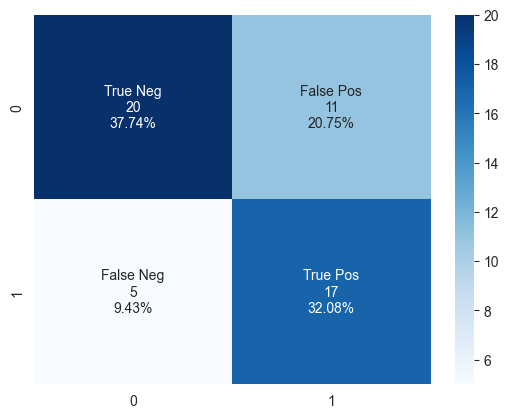

In [34]:
plot_confusion_matrix(test_y[0], logistic_regression_model['Y_prediction_test'][0])

In [35]:
print(classification_report(test_y[0], logistic_regression_model['Y_prediction_test'][0]))

              precision    recall  f1-score   support

           0       0.80      0.65      0.71        31
           1       0.61      0.77      0.68        22

    accuracy                           0.70        53
   macro avg       0.70      0.71      0.70        53
weighted avg       0.72      0.70      0.70        53




Precision

For class 0, the precision is 0.8, indicating that among all instances predicted as class 0, 80% were correctly classified.
For class 1, the precision is 0.61, meaning that 61% of instances predicted as class 1 were indeed class 1.

Recall

For class 0, the recall is 0.65, indicating that the model correctly identified 65% instances of class 0.
For class 1, the recall is 0.77, suggesting that the model missed 23% instances of class 1.

### Checking quality with validation set ###

## Validation set ##

In [61]:
ds = h5py.File(conf.dataset_path, "r")
x_fig_valid = np.array(ds['x_fig_valid'][:])
y_fig_valid = np.array(ds['y_fig_valid'][:])
y_fig_valid = y_fig_valid.reshape((1, y_fig_valid.shape[0]))
ds.close()

In [62]:
valid_x_flatten = x_fig_valid.reshape(x_fig_valid.shape[0],-1).T / 255

In [75]:
weights, bias = logistic_regression_model['w'], logistic_regression_model['b']
y_valid_pred = predict(weights, bias, valid_x_flatten)

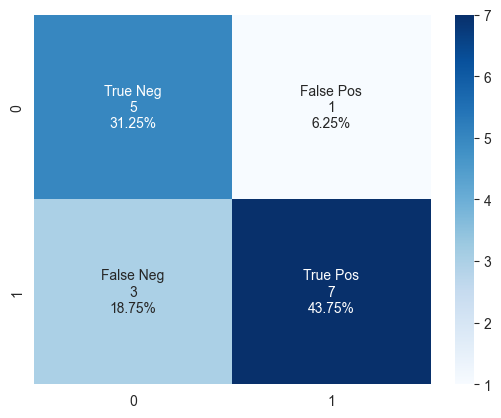

In [82]:
plot_confusion_matrix(y_fig_valid[0], y_valid_pred[0])

In [83]:
print(classification_report(y_fig_valid[0], y_valid_pred[0]))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.88      0.70      0.78        10

    accuracy                           0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16



<a name='6'></a>
# Predicting the Presence of Tables on a Document Page #

<a name='6-1'></a>
## Preparing train and test sets ##

In [36]:
train_x_table, test_x_table, train_y_table, test_y_table = get_train_test_set(dataset_path="/Users/michael/Projects/tables_recognition/data/taub_dataset.h5", problem="table")

In [37]:
train_x_table_stand = train_x_table.reshape(train_x.shape[0],-1).T / 255
test_x_table_stand = test_x_table.reshape(test_x.shape[0],-1).T / 255

<a name='6-2'></a>
## Choosing learning rate ##

In [38]:
learning_rates = [0.01, 0.001, 0.0001, 0.00003]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_x_table_stand, train_y_table, test_x_table_stand, test_y_table, num_iterations=2100, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

Training a model with learning rate: 0.01


/var/folders/8m/pdb3kxls26vfh6fx96vt11380000gp/T/ipykernel_34506/1526006666.py:7: RuntimeWarning: overflow encountered in exp
  s = 1 / (1+ np.exp(-z))
/var/folders/8m/pdb3kxls26vfh6fx96vt11380000gp/T/ipykernel_34506/2450089686.py:18: RuntimeWarning: divide by zero encountered in log
  cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m
/var/folders/8m/pdb3kxls26vfh6fx96vt11380000gp/T/ipykernel_34506/2450089686.py:18: RuntimeWarning: invalid value encountered in multiply
  cost = - np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) / m



-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------

Training a model with learning rate: 3e-05

-------------------------------------------------------



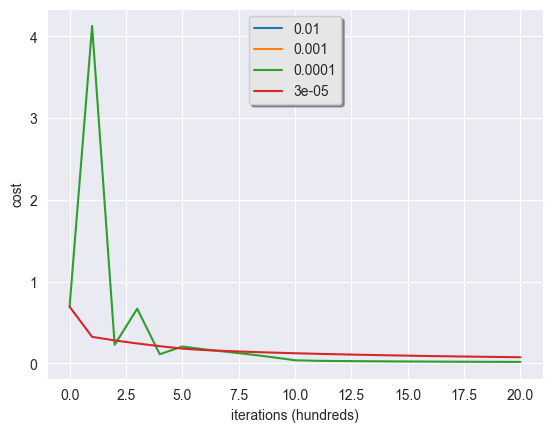

In [39]:
for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
# Set Y-axis limit to 10
# plt.ylim(0, 10)

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

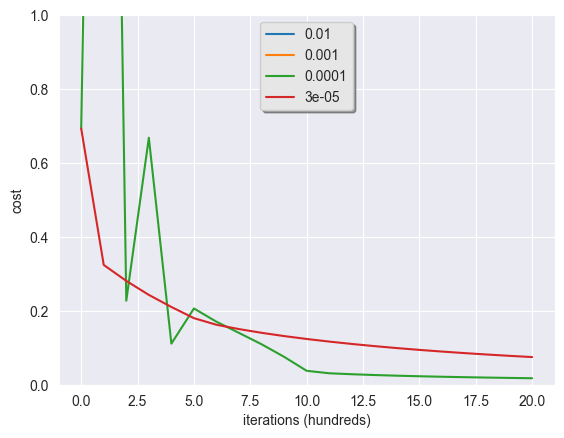

In [40]:
for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
# Set Y-axis limit to 10
plt.ylim(0, 1)

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

<a name='6-3'></a>
## Training a model ##

In [41]:
logistic_regression_model_table = model(train_x_table_stand, train_y_table, test_x_table_stand, test_y_table, num_iterations=2100, learning_rate=0.00003, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.324088
Cost after iteration 200: 0.280916
Cost after iteration 300: 0.243044
Cost after iteration 400: 0.210362
Cost after iteration 500: 0.180089
Cost after iteration 600: 0.162220
Cost after iteration 700: 0.150527
Cost after iteration 800: 0.140464
Cost after iteration 900: 0.131636
Cost after iteration 1000: 0.123780
Cost after iteration 1100: 0.116717
Cost after iteration 1200: 0.110317
Cost after iteration 1300: 0.104486
Cost after iteration 1400: 0.099149
Cost after iteration 1500: 0.094248
Cost after iteration 1600: 0.089734
Cost after iteration 1700: 0.085566
Cost after iteration 1800: 0.081709
Cost after iteration 1900: 0.078135
Cost after iteration 2000: 0.074816
train accuracy: 97.54901960784314 %
test accuracy: 92.45283018867924 %


<a name='6-5'></a>
## Cost function / gradients plot ##

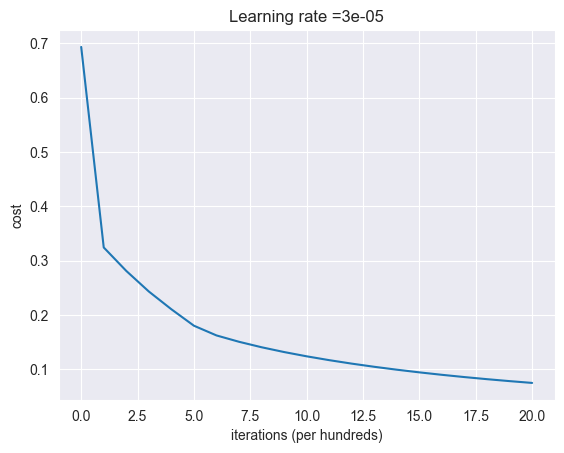

In [42]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model_table['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model_table["learning_rate"]))
plt.show()

<a name='6-4'></a>
## Checking results ##

y = 1, you predicted that it is a "0"


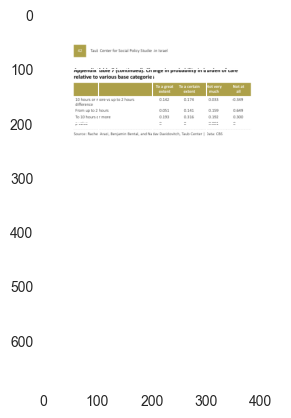

y = 1, we predicted that it is a "0"


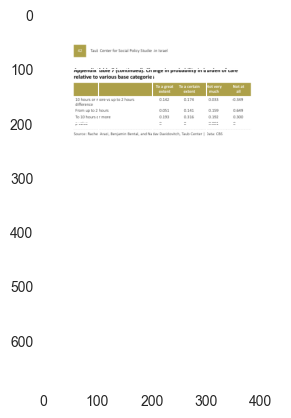

In [47]:
# Example of a picture that was wrongly classified.
index = 3
plt.imshow(test_x_table[index])
print ("y = " + str(test_y_table[0,index]) + ", we predicted that it is a \"" + str(int(1-logistic_regression_model_table['Y_prediction_test'][0,index])) +  "\"")

y = 1, you predicted that it is a "1"


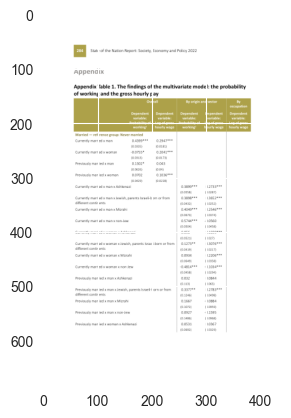

y = 1, we predicted that it is a "1"


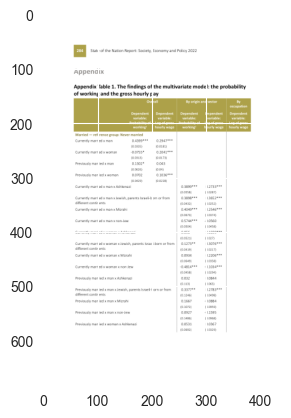

In [48]:
# Example of a picture that was correctly classified.
index = 1
plt.imshow(test_x_table[index])
print ("y = " + str(test_y_table[0,index]) + ", we predicted that it is a \"" + str(int(1-logistic_regression_model_table['Y_prediction_test'][0,index])) +  "\"")

<a name='6-6'></a>
## Measuring quality ##

<Axes: >

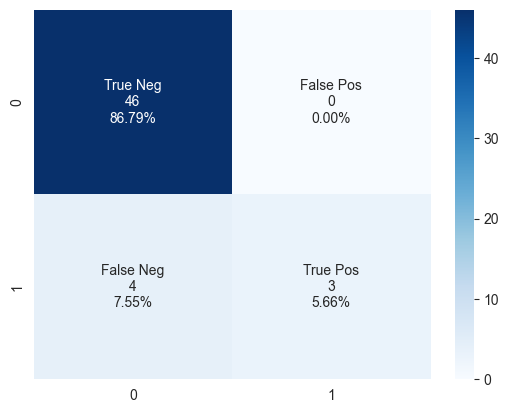

In [45]:
cf_matrix = confusion_matrix(test_y_table[0], logistic_regression_model_table['Y_prediction_test'][0])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [46]:
print(classification_report(test_y_table[0], logistic_regression_model_table['Y_prediction_test'][0]))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        46
           1       1.00      0.43      0.60         7

    accuracy                           0.92        53
   macro avg       0.96      0.71      0.78        53
weighted avg       0.93      0.92      0.91        53



Precision

For class 0, the precision is 0.92, indicating that among all instances predicted as class 0, 92% were correctly classified.
For class 1, the precision is 1, meaning that all instances predicted as class 1 were indeed class 1.

Recall

For class 0, the recall is 1.00, indicating that the model correctly identified all instances of class 0.
However, for class 1, the recall is 0.43, suggesting that the model missed some instances of class 1.

<a name='7'></a>
# Summary #
Quality overall is not bad for such simple model but not complete. There is huge room, even a hall, even an island for investigations and further improvements both from data and model sides, such as:
- Comparing different models
- Challenging model on larger evaluation sets
- Adding different types of documents
- Adding different types of figures
- Adding different types of tables
- Trying approaches with text extraction

etc. etc.